# INDIA MONSOON EXAMPLE

1) Load Data and Libraries. Data are from IRIDL NMME Archive- CanSIPSv2, NCEP-CFSv2, COLA-RSMAS-CCSM4, and NASA-GEOSS2S

In [1]:
import src as xc
import xarray as xr 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
from pathlib import Path

In [2]:
Y = xr.open_dataset('INDIAMONSOON/observations.nc', decode_times=False).expand_dims({'M':[0]}).rename({'time':'T', 'LONGITUDE':'X', 'LATITUDE':'Y'})
X = xr.concat([xr.open_dataset(i, decode_times=False, engine='netcdf4') for i in ['INDIAMONSOON/CANSIPSV2_HCST.NC', 'INDIAMONSOON/NASAGEOSS2S_HCST.NC', 'INDIAMONSOON/CCSM4_HCST.NC', 'INDIAMONSOON/NCEPCFSV2_HCST.NC'] ], 'M').mean('L').assign_coords({'M':[i for i in range(4)]})
F = xr.concat([xr.open_dataset(i, decode_times=False, engine='netcdf4') for i in ['INDIAMONSOON/CANSIPSV2_FCST.NC', 'INDIAMONSOON/NASAGEOSS2S_FCST.NC', 'INDIAMONSOON/CCSM4_FCST.NC', 'INDIAMONSOON/NCEPCFSV2_FCST.NC'] ], 'M').mean('L').assign_coords({'M':[i for i in range(4)]})

In [3]:
X.S.attrs['calendar'] = '360_day'
F.S.attrs['calendar'] = '360_day'
X.S.attrs['units'] = 'months since 1960-01-01'
F.S.attrs['units'] = 'months since 1960-01-01'
Y = xr.decode_cf(Y).rf
X = xr.decode_cf(X).prec
F = xr.decode_cf(F).prec


2) Leave-3-Out Crossvalidation

In [4]:
%%timeit
mlr = xc.rExtremeLearningMachine()
mlr.fit(X, Y)

129 ms ± 984 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
if not Path('INDIAMONSOON2/HCSTS_{}.NC'.format(xc.deterministic_mmes[0].__name__.upper()[1:])).is_file():
    results = [xc.cross_validate(i, X, Y, ND=5, verbose=True) for i in [xc.mExtremeLearningMachine, xc.mMultipleRegression, xc.mEnsembleMean, xc.mBiasCorrectedEnsembleMean]]
    for i in range(len(results)):
        results[i].to_netcdf('INDIAMONSOON2/HCSTS_{}.NC'.format((xc.deterministic_mmes[i].__name__ if i < 3 else xc.deterministic_mmes[i+1].__name__).upper()[1:]))
else:
    results = [ xr.open_dataset('INDIAMONSOON2/HCSTS_{}.NC'.format((xc.deterministic_mmes[i].__name__ if i < 3 else xc.deterministic_mmes[i+1].__name__).upper()[1:]), decode_times=False) for i in range(len(xc.deterministic_mmes)-1) ]
     
    for i in range(len(results)):
        results[i].S.attrs['calendar'] = '360_day'
        results[i].S.attrs['units'] = 'months since 1960-01-01'
        results[i] = xr.decode_cf(results[i])
    

 CROSSVALIDATING mExtremeLearningMachine:  [*************************] (13/13) 0:00:09.214497
 CROSSVALIDATING mMultipleRegression:  [*************************] (13/13) 0:00:18.068542
 CROSSVALIDATING mEnsembleMean:  [*************************] (13/13) 0:00:00.187614
 CROSSVALIDATING mBiasCorrectedEnsembleMean:  [*************************] (13/13) 0:00:00.365323


3) Calculate skill scores (Index Of Agreement, Pearson Correlation)

In [6]:
pearson_scores = [ xc.Pearson(results[i].hindcasts, Y, x_sample_dim='S', lat_chunks=2, lon_chunks=2, rechunk=True) for i in range(len(results))]
index_of_agreement = [ xc.IndexOfAgreement(results[i].hindcasts, Y, x_sample_dim='S',  lat_chunks=2, lon_chunks=2, rechunk=True) for i in range(len(results))]
kges = [ xc.KlingGuptaEfficiency(results[i].hindcasts, Y, x_sample_dim='S', lat_chunks=2, lon_chunks=2, rechunk=True) for i in range(len(results))]

4) Plot Skill Scores

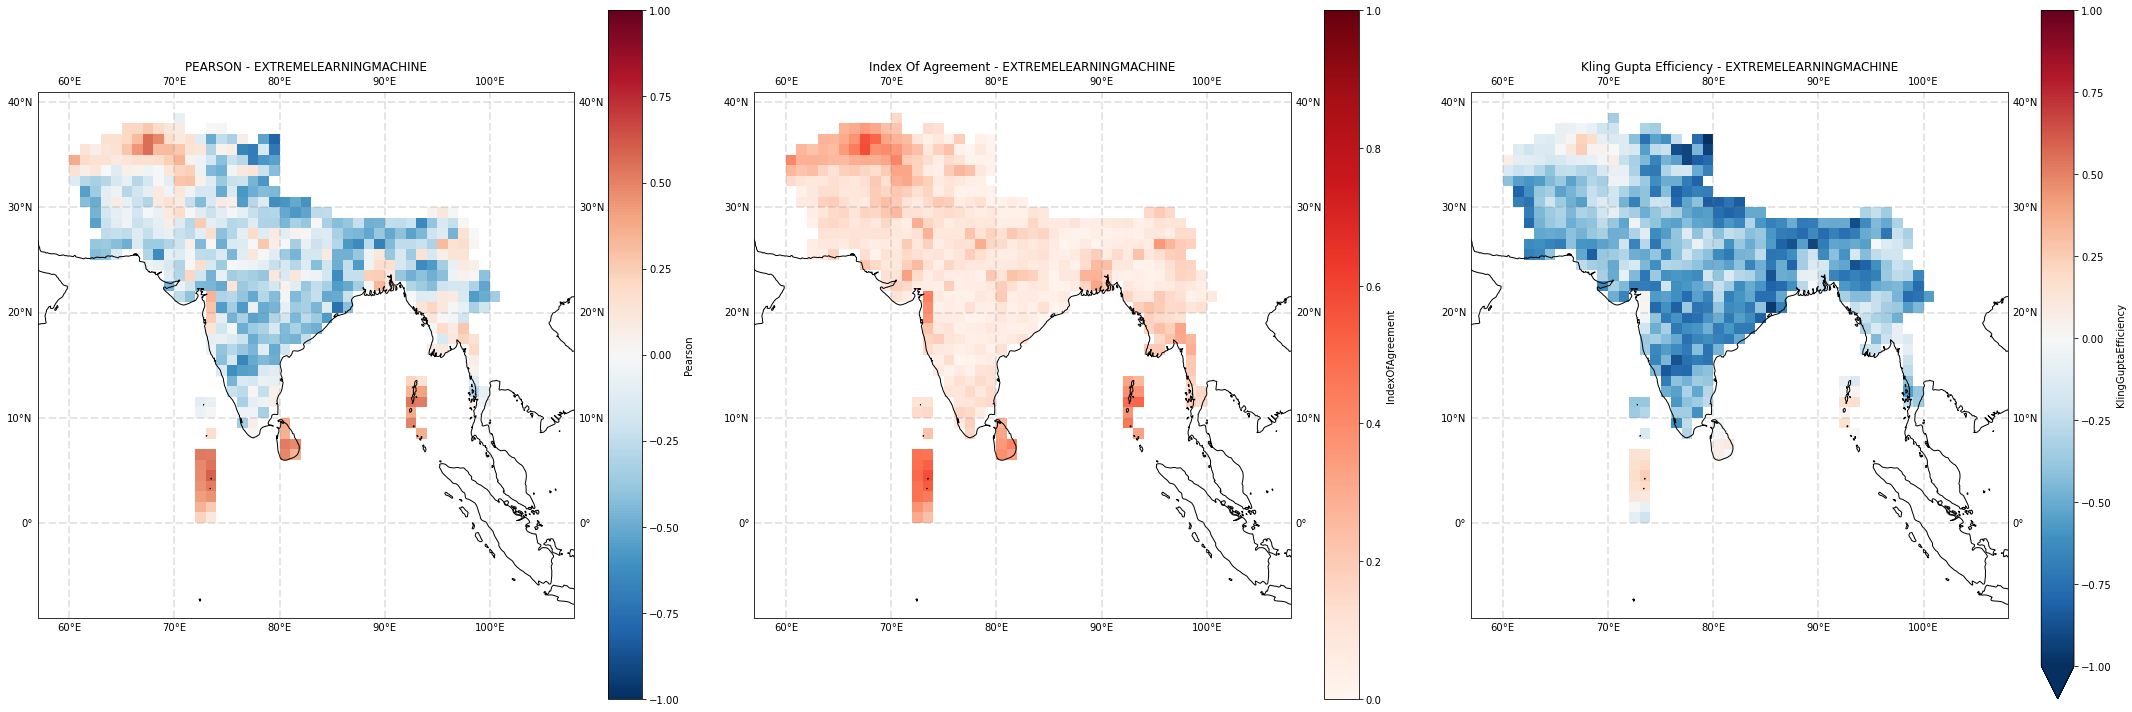

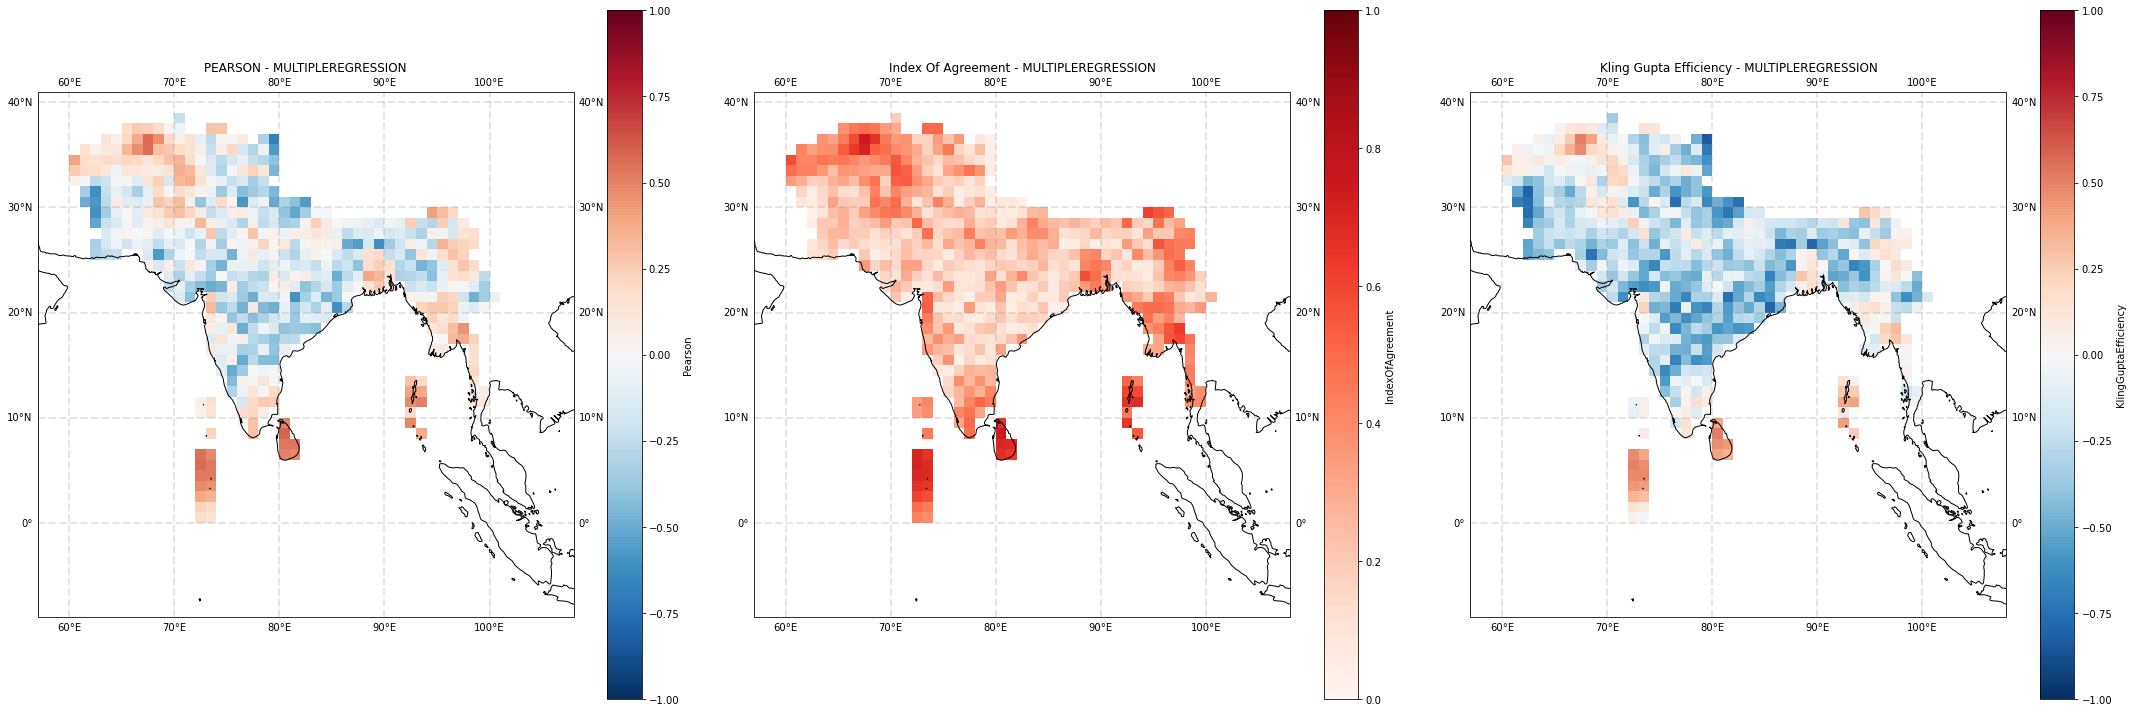

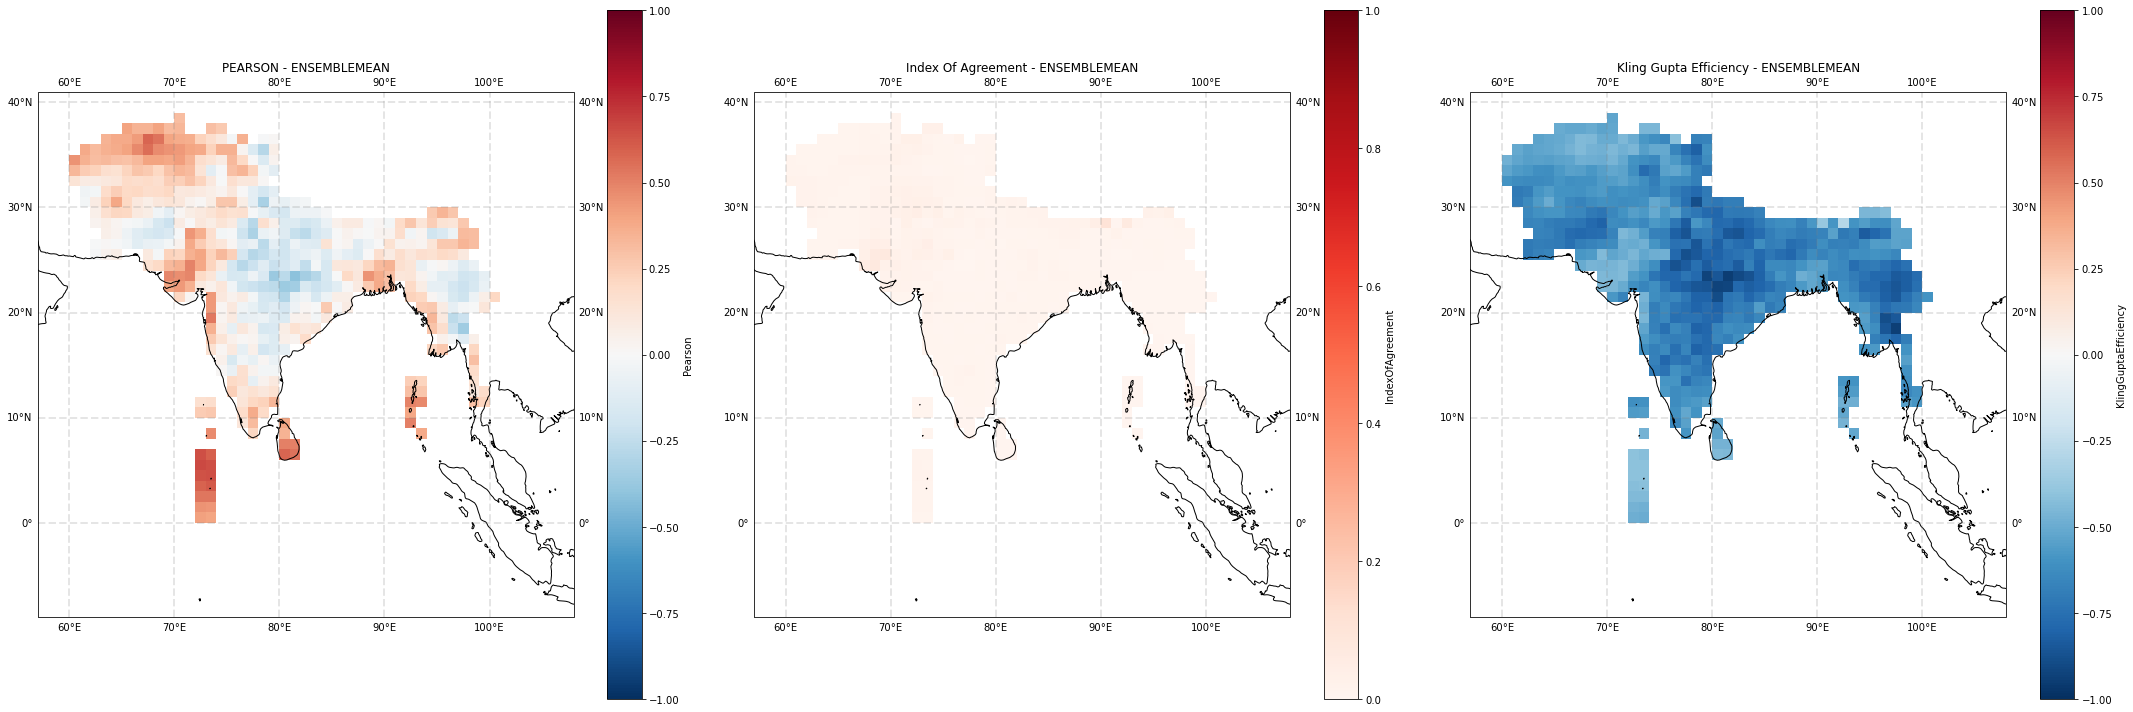

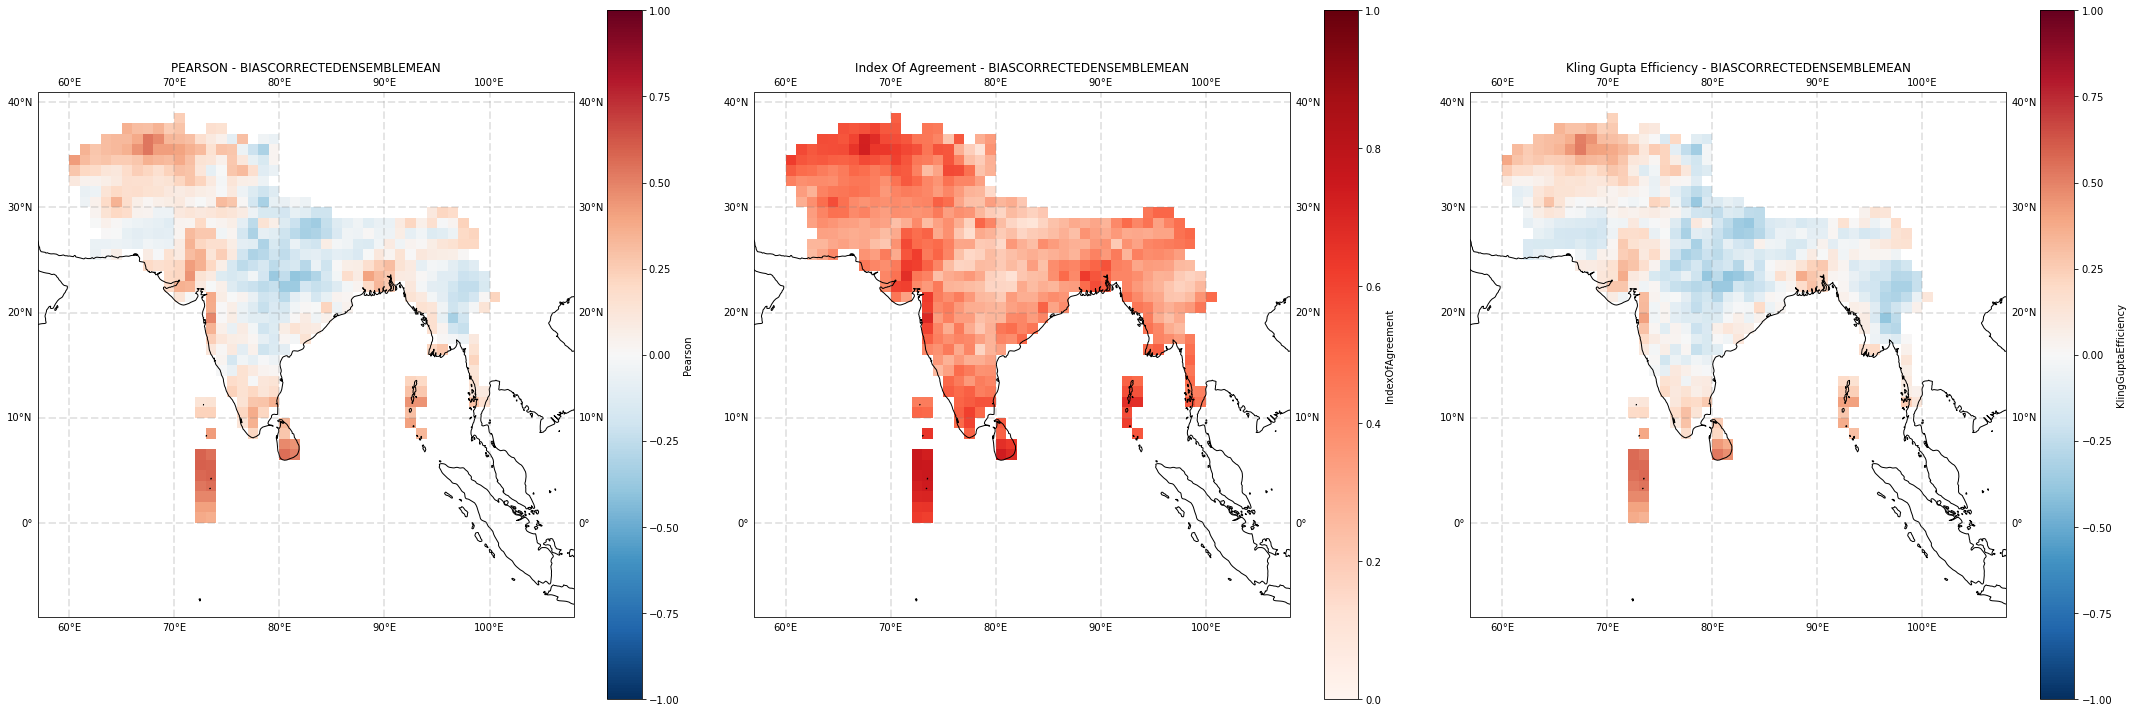

In [8]:
for i in range(len(results)):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), subplot_kw={'projection':ccrs.PlateCarree()})
    pearson_scores[i].isel(SKILLDIM=0, M=0).plot(ax=ax[0], vmin=-1, vmax=1, cmap='RdBu_r')
    ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  linewidth=2, color='gray', alpha=0.2, linestyle='--')
    ax[0].coastlines()
    ax[0].set_title('PEARSON - ' + [xc.mExtremeLearningMachine, xc.mMultipleRegression, xc.mEnsembleMean, xc.mBiasCorrectedEnsembleMean][i].__name__.upper()[1:])
    index_of_agreement[i].isel(SKILLDIM=0, M=0).plot(ax=ax[1], vmin=0, vmax=1.0, cmap='Reds')
    ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  linewidth=2, color='gray', alpha=0.2, linestyle='--')
    ax[1].coastlines()
    ax[1].set_title('Index Of Agreement - ' + [xc.mExtremeLearningMachine, xc.mMultipleRegression, xc.mEnsembleMean, xc.mBiasCorrectedEnsembleMean][i].__name__.upper()[1:])
    kges[i].isel(SKILLDIM=0, M=0).plot(ax=ax[2], vmin=-1, vmax=1.0, cmap='RdBu_r')
    ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  linewidth=2, color='gray', alpha=0.2, linestyle='--')
    ax[2].coastlines()
    ax[2].set_title('Kling Gupta Efficiency - ' + [xc.mExtremeLearningMachine, xc.mMultipleRegression, xc.mEnsembleMean, xc.mBiasCorrectedEnsembleMean][i].__name__.upper()[1:])
    plt.tight_layout()
    #fig.savefig('INDIAMONSOON/SKILLMAPS_{}'.format((xc.deterministic_mmes[i].__name__ if i < 3 else xc.deterministic_mmes[i+1].__name__).upper()[1:]))
    plt.show()

5) Examine Hindcasts and Skill over Mumbai


Run (from a command line):
```
python interactive_india_monsoon.py [lat value] [lon value]
```
to examine interactive line plots at that point!